In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

In [2]:
from dataset import load_svhn
from knn import KNN
from metrics import binary_classification_metrics, multiclass_accuracy

2


(-0.5, 31.5, 31.5, -0.5)

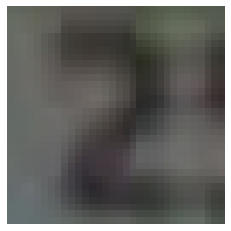

In [3]:
train_X, train_y, test_X, test_y = load_svhn("data", max_train=100, max_test=100)
image = test_X[0]
print(test_y[0])
plt.imshow(image.astype(np.uint8))
plt.axis('off')

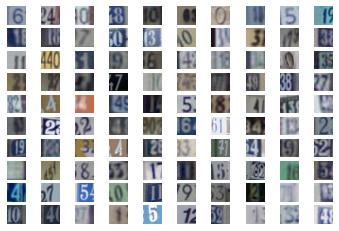

In [4]:
plot_index = 1
for i in range(100):
    plt.subplot(10, 10, plot_index)
    image = train_X[i]
    plt.imshow(image.astype(np.uint8))
    plt.axis('off')
    plot_index += 1

# Сначала реализуем KNN для бинарной классификации

В качестве задачи бинарной классификации тренируем модель, которая будет отличать цифру 0 от цифры 9.

In [5]:
# First, let's prepare the labels and the source data

# Only select 0s and 9s
binary_train_mask = (train_y == 0) | (train_y == 9)
binary_train_X = train_X[binary_train_mask]
binary_train_y = train_y[binary_train_mask]

binary_test_mask = (test_y == 0) | (test_y == 9)
binary_test_X = test_X[binary_test_mask]
binary_test_y = test_y[binary_test_mask] 


# Reshape to 1-dimensional array [num_samples, 32*32*3]
binary_train_X = binary_train_X.reshape(binary_train_X.shape[0],-1)
binary_test_X = binary_test_X.reshape(binary_test_X.shape[0],-1)

In [6]:
# Create the classifier and call fit to train the model
# KNN just remembers all the data
knn_classifier = KNN(k=1)
knn_classifier.fit(binary_train_X, binary_train_y)

Последовательно реализуйте функции `compute_distances_two_loops`, `compute_distances_one_loop` и `compute_distances_no_loops`
в файле `knn.py`.

Эти функции строят массив расстояний между всеми векторами в тестовом наборе и в тренировочном наборе.  
В результате они должны построить массив размера `(num_test, num_train)`, где координата `[i][j]` соотвествует расстоянию между i-м вектором в test (`test[i]`) и j-м вектором в train (`train[j]`).

Для простоты реализации мы будем использовать в качестве расстояния меру L1 Manhatatn distance 

In [7]:
# TODO: implement compute_distances_two_loops in knn.py
dists1 = knn_classifier.compute_distances_two_loops(binary_test_X)
assert np.isclose(dists1[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))

In [8]:
# TODO: implement compute_distances_one_loop in knn.py
dists2 = knn_classifier.compute_distances_one_loop(binary_test_X)
assert np.isclose(dists2[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))

In [9]:
# TODO: implement compute_distances_no_loops in knn.py
dists3 = knn_classifier.compute_distances_no_loops(binary_test_X)
assert np.isclose(dists3[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))

In [10]:
print(np.allclose(dists1, dists2))
print(np.allclose(dists2, dists3))

True
True


In [11]:
# Lets look at the performance difference
%timeit knn_classifier.compute_distances_two_loops(binary_test_X)
%timeit knn_classifier.compute_distances_one_loop(binary_test_X)
%timeit knn_classifier.compute_distances_no_loops(binary_test_X)

2.12 ms ± 89.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
832 µs ± 15.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.62 ms ± 140 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
# TODO: implement predict_labels_binary in knn.py
prediction = knn_classifier.predict(binary_test_X)
print(prediction)
print(binary_test_y)

[0 9 0 9 0 0 0 0 0 9 9 0 0 9 0 9]
[0 0 0 9 9 0 0 0 0 9 0 9 0 0 0 0]


In [13]:
# TODO: implement binary_classification_metrics in metrics.py
precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y, 0, 9)
print("KNN with k = %s" % knn_classifier.k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

KNN with k = 1
Accuracy: 0.62, Precision: 0.33, Recall: 0.50, F1: 0.40


In [14]:
# Let's put everything together and run KNN with k=3 and see how we do
knn_classifier_3 = KNN(k=3)
knn_classifier_3.fit(binary_train_X, binary_train_y)
prediction = knn_classifier_3.predict(binary_test_X)

precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y, 0, 9)
print("KNN with k = %s" % knn_classifier_3.k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

KNN with k = 3
Accuracy: 0.56, Precision: 0.29, Recall: 0.50, F1: 0.36


# Кросс-валидация (cross-validation)

Попробуем найти лучшее значение параметра k для алгоритма KNN! 

Для этого мы воспользуемся k-fold cross-validation. Мы разделим тренировочные данные на 5 фолдов (folds), и по очереди будем использовать каждый из них в качестве проверочных данных (validation data), а остальные -- в качестве тренировочных (training data).

В качестве финальной оценки эффективности k мы усредним значения F1 score на всех фолдах.
После этого мы просто выберем значение k с лучшим значением метрики.

In [15]:
# Find the best k using cross-validation based on F1 score
num_folds = 5
train_folds_X = []
train_folds_y = []



# TODO: split the training data in 5 folds and store them in train_folds_X/train_folds_y

k_choices = [1, 2, 3, 5, 8, 10, 15, 20, 25, 50]
k_to_f1 = {}  # dict mapping k values to mean F1 scores (int -> float)

for k in k_choices:
    # TODO: perform cross-validation
    # Go through every fold and use it for testing and all other folds for training
    # Perform training and produce F1 score metric on the validation dataset
    # Average F1 from all the folds and write it into k_to_f1

    pass

for k in sorted(k_to_f1):
    print('k = %d, f1 = %f' % (k, k_to_f1[k]))

### Проверим, как хорошо работает лучшее значение k на тестовых данных (test data)

In [16]:
# TODO Set the best k to the best value found by cross-validation
best_k = 1

best_knn_classifier = KNN(k=best_k)
best_knn_classifier.fit(binary_train_X, binary_train_y)
prediction = best_knn_classifier.predict(binary_test_X)

precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y, 0, 9)
print("Best KNN with k = %s" % best_k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

Best KNN with k = 1
Accuracy: 0.62, Precision: 0.33, Recall: 0.50, F1: 0.40


# Многоклассовая классификация (multi-class classification)

Переходим к следующему этапу - классификации на каждую цифру.

In [17]:
# Now let's use all 10 classes
train_X = train_X.reshape(train_X.shape[0], -1)
test_X = test_X.reshape(test_X.shape[0], -1)

knn_classifier = KNN(k=1)
knn_classifier.fit(train_X, train_y)

In [18]:
# TODO: Implement predict_labels_multiclass
predict = knn_classifier.predict(test_X)

In [19]:
# TODO: Implement multiclass_accuracy
accuracy = multiclass_accuracy(predict, test_y)
print("Accuracy: %4.2f" % accuracy)

Accuracy: 0.21


Снова кросс-валидация. Теперь нашей основной метрикой стала точность (accuracy), и ее мы тоже будем усреднять по всем фолдам.

In [20]:
# Find the best k using cross-validation based on accuracy
num_folds = 5
train_folds_X = []
train_folds_y = []

# TODO: split the training data in 5 folds and store them in train_folds_X/train_folds_y

k_choices = [1, 2, 3, 5, 8, 10, 15, 20, 25, 50]
k_to_accuracy = {}

for k in k_choices:
    # TODO: perform cross-validation
    # Go through every fold and use it for testing and all other folds for validation
    # Perform training and produce accuracy metric on the validation dataset
    # Average accuracy from all the folds and write it into k_to_accuracy
    pass

for k in sorted(k_to_accuracy):
    print('k = %d, accuracy = %f' % (k, k_to_accuracy[k]))

### Финальный тест - классификация на 10 классов на тестовой выборке (test data)

Если все реализовано правильно, вы должны увидеть точность не менее **0.2**.

In [21]:
# TODO Set the best k as a best from computed
best_k = 1

best_knn_classifier = KNN(k=best_k)
best_knn_classifier.fit(train_X, train_y)
prediction = best_knn_classifier.predict(test_X)

# Accuracy should be around 20%!
accuracy = multiclass_accuracy(prediction, test_y)
print("Accuracy: %4.2f" % accuracy)

Accuracy: 0.21
